<a href="https://colab.research.google.com/github/Nicholas-Sidharta12365/colab-repository-isyaratku/blob/main/IsyaratKu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isyaratku With ResNet50

description maybe

## Import Libraries

In [ ]:
import tensorflow as tf
import tensorflow.lite as tflite
import cv2
import numpy as np
import pandas as pd
import csv
import string
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential

from IPython.display import clear_output
import os

In [ ]:
!pip install kaggle

## Import Data

In [ ]:
!kaggle datasets download -d agungmrf/indonesian-sign-language-bisindo
!kaggle datasets download -d datamunge/sign-language-mnist

Dataset URL: https://www.kaggle.com/datasets/agungmrf/indonesian-sign-language-bisindo
License(s): unknown
 98% 1.34G/1.36G [00:18<00:00, 139MB/s]
100% 1.36G/1.36G [00:18<00:00, 79.8MB/s]
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 78% 49.0M/62.6M [00:00<00:00, 261MB/s]
100% 62.6M/62.6M [00:00<00:00, 264MB/s]


In [ ]:
!mkdir ./datasets
!rm -rf sample_data

!unzip -o indonesian-sign-language-bisindo.zip -d datasets/indonesian-sign-language-bisindo
!unzip -o sign-language-mnist.zip -d datasets/sign-language-mnist

clear_output()

bisindo_data_dir = '/content/datasets/indonesian-sign-language-bisindo'
mnist_data_dir = '/content/datasets/sign-language-mnist'

In [ ]:
!ls -al ./datasets/

total 20
drwxr-xr-x 4 root root 4096 Jun  1 16:13 .
drwxr-xr-x 1 root root 4096 Jun  1 16:13 ..
drwxr-xr-x 3 root root 4096 Jun  1 16:13 indonesian-sign-language-bisindo
drwxr-xr-x 4 root root 4096 Jun  1 16:13 sign-language-mnist


## Use GPU If available

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

Num GPUs Available:  1


## ASL

### Data Preparation and Exploration

In [ ]:
train_set = '/content/datasets/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv'
test_set = '/content/datasets/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv'

In [ ]:
with open(train_set) as train_file:
  line = train_file.readline()
  print(f'first line or header:\n{line}')
  line = train_file.readline()
  print(f'subquent line or data points:\n{line}')

first line or header:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,

In [ ]:
def parse_data(file):
  with open(file) as filename:
    csv_reader = csv.reader(filename, delimiter=',')

    next(csv_reader)
    data = list(csv_reader)
    labels=[]
    images=[]

  for row in data:
    labels.append(float(row[0]))
    images.append([float(x) for x in row[1:]])
  labels = np.array(labels)
  images = np.array(images)
  images = images.reshape(-1, 28, 28)

  return images, labels

In [ ]:
train_images, train_labels = parse_data(train_set)
test_images, test_labels = parse_data(test_set)

In [ ]:
print(f'Training images has shape: {train_images.shape}')
print(f'Training labels has shape: {train_labels.shape}')
print(f'Test images has shape: {test_images.shape}')
print(f'Test labels has shape: {test_labels.shape}')

Training images has shape: (27455, 28, 28)
Training labels has shape: (27455,)
Test images has shape: (7172, 28, 28)
Test labels has shape: (7172,)


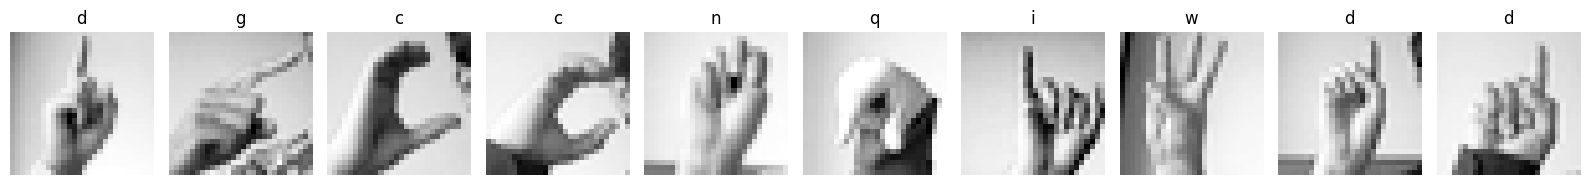

In [ ]:
def plot_categories(train_images, train_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = train_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(f"{letters[int(train_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(train_images, train_labels)

In [ ]:
def generators(train_images, train_labels, test_images, test_labels):
  train_images = np.expand_dims(train_images, axis=-1)
  test_images = np.expand_dims(test_images, axis=-1)

  train_generator = ImageDataGenerator(rescale=1./255.,
                                      rotation_range=20,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True
                                      )
  asl_train_data = train_generator.flow(x = train_images,
                                        y = train_labels,
                                        batch_size = 20) #awalnya 32

  test_generator = ImageDataGenerator(rescale=1./255.)
  asl_test_data = test_generator.flow(x = test_images,
                                      y = test_labels,
                                      batch_size = 20)  #awalnya 32
  return asl_train_data, asl_test_data

In [ ]:
asl_train_data, asl_test_data = generators(train_images, train_labels, test_images, test_labels)
print(f'Training images has shape: {asl_train_data.x.shape}')
print(f'Test images has shape: {asl_test_data.x.shape}')

Training images has shape: (27455, 28, 28, 1)
Test images has shape: (7172, 28, 28, 1)


### Build and Create Base Model

In [ ]:
def feature_extractor(input):
  input_rgb = tf.image.grayscale_to_rgb(input) #karna ternyata harus rgb kalo resnet
  base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                                    include_top=False,
                                                    weights='imagenet')
  for layer in base_model.layers:
    layer.trainable = False
  return base_model(input_rgb)

### Build Sequential Model Architecture


In [ ]:
def architecture(input):
    x = tf.keras.layers.GlobalAveragePooling2D()(input)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(26, activation='softmax')(x)
    return x

In [ ]:
# def final_model():
#   input = tf.keras.layers.Input(shape=(28, 28, 1))
#   resize = tf.keras.layers.UpSampling2D(size=(8,8))(input)  #karna minimal 32
#   resnet = feature_extractor(resize)
#   output = architecture(resnet)
#   model = tf.keras.Model(inputs=input, outputs = output)

#   model.compile(optimizer='SGD',
#                 loss='sparse_categorical_crossentropy',
#                 metrics= ['accuracy'])
#   return model

In [ ]:
def final_model():
    input = tf.keras.layers.Input(shape=(28, 28, 1))
    resize = tf.keras.layers.UpSampling2D(size=(8,8))(input)  #minimum 32
    x = tf.keras.layers.RandomFlip("horizontal")(resize)
    x = tf.keras.layers.RandomRotation(0.2)(x)
    x = tf.keras.layers.RandomZoom(0.2, 0.2)(x)
    resnet = feature_extractor(x)
    x = tf.keras.layers.BatchNormalization()(resnet)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = architecture(x)
    model = tf.keras.Model(inputs=input, outputs = x)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                loss='sparse_categorical_crossentropy',
                metrics= ['accuracy'])
    return model

In [ ]:
model = final_model()
model.summary()

94765736/94765736 [==============================] - 4s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 1)       0         
 D)                                                              
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 1)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 1)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 1)       0         
                                                                 
 tf.image.grayscale_to_rgb   (None, 224, 224, 3)       0     

### Configure and Train Model

In [ ]:
history = model.fit(asl_train_data, epochs=100, validation_data=asl_test_data, batch_size=64)

Epoch 1/100
858/858 [==============================] - 129s 139ms/step - loss: 2.9969 - accuracy: 0.1022 - val_loss: 2.5575 - val_accuracy: 0.1704
Epoch 2/100
858/858 [==============================] - 116s 136ms/step - loss: 2.8198 - accuracy: 0.1465 - val_loss: 2.3217 - val_accuracy: 0.2514
Epoch 3/100
858/858 [==============================] - 117s 136ms/step - loss: 2.7249 - accuracy: 0.1698 - val_loss: 2.0412 - val_accuracy: 0.3015
Epoch 4/100
858/858 [==============================] - 117s 136ms/step - loss: 2.6609 - accuracy: 0.1816 - val_loss: 2.0922 - val_accuracy: 0.3204
Epoch 5/100
858/858 [==============================] - 136s 158ms/step - loss: 2.6121 - accuracy: 0.1974 - val_loss: 2.1317 - val_accuracy: 0.2804
Epoch 6/100
858/858 [==============================] - 117s 136ms/step - loss: 2.5761 - accuracy: 0.2046 - val_loss: 1.9857 - val_accuracy: 0.3165
Epoch 7/100
858/858 [==============================] - 117s 136ms/step - loss: 2.5425 - accuracy: 0.2178 - val_loss: 1

### Review Training Curves and Metrics

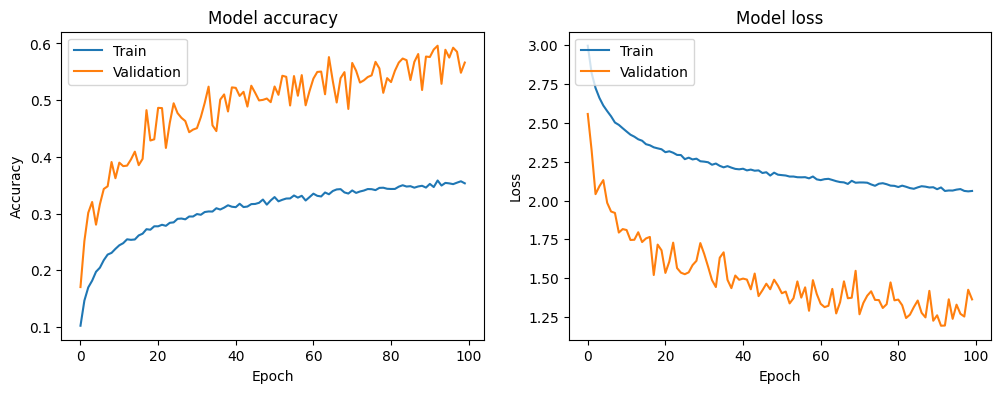

In [ ]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

### Hyperparameter Tuning and Reconfigure Layers

### Convert to TFLite

In [ ]:
# Save the trained model
model.save('asl_model.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('asl_model.tflite', 'wb') as f:
    f.write(tflite_model)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Save Model

In [ ]:
model.save('asl_model.h5')
model.save('asl_saved_model', save_format='tf')

## BISINDO

### Data Preparation and Exploration

In [ ]:
images_train = '/content/datasets/indonesian-sign-language-bisindo/bisindo/images/train'
labels_train = '/content/datasets/indonesian-sign-language-bisindo/bisindo/labels/train'

images_test = '/content/datasets/indonesian-sign-language-bisindo/bisindo/images/val'
labels_test = '/content/datasets/indonesian-sign-language-bisindo/bisindo/labels/val'

In [ ]:
def dataset(dir):
  path = []

  for letter in os.listdir(dir):
    letter_dir = os.path.join(dir, letter)

    for name in os.listdir(letter_dir):
      path.append(os.path.join(letter_dir, name))
  return path

In [ ]:
b_images_train = dataset(images_train)
b_labels_train = dataset(labels_train)

b_images_test = dataset(images_test)
b_labels_test = dataset(labels_test)

In [ ]:
print(f'There are {len(b_images_train)} images for training')
print(f'There are {len(b_labels_train)} labels for training')
print(f'There are {len(b_images_test)} images for test')
print(f'There are {len(b_labels_test)} labels for test')

There are 9169 images for training
There are 9168 labels for training
There are 2301 images for test
There are 2301 labels for test


### Build and Create Base Model

### Build Sequential Model Architecture


### Configure and Train Model

### Review Training Curves and Metrics

### Hyperparameter Tuning and Reconfigure Layers

### Convert to TFLite

### Save Model

## SANDBOX

In [ ]:
def architecture_coba():
  model_coba = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28,1)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(25, activation='softmax')
  ])

  model_coba.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
  return model_coba

In [ ]:
model_coba = architecture_coba()
model_coba.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 128)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 64)         

In [ ]:
history_coba = model_coba.fit(asl_train_data, epochs=100, validation_data=asl_test_data, batch_size=20)

Epoch 1/100
1373/1373 [==============================] - 17s 12ms/step - loss: 1.9180 - accuracy: 0.3688 - val_loss: 1.3425 - val_accuracy: 0.4993
Epoch 2/100
1373/1373 [==============================] - 18s 13ms/step - loss: 1.7391 - accuracy: 0.4197 - val_loss: 1.0541 - val_accuracy: 0.6351
Epoch 3/100
1373/1373 [==============================] - 17s 13ms/step - loss: 1.6502 - accuracy: 0.4468 - val_loss: 1.0643 - val_accuracy: 0.6173
Epoch 4/100
1373/1373 [==============================] - 17s 13ms/step - loss: 1.5656 - accuracy: 0.4769 - val_loss: 1.1028 - val_accuracy: 0.5848
Epoch 5/100
1373/1373 [==============================] - 20s 15ms/step - loss: 1.5015 - accuracy: 0.4932 - val_loss: 0.8903 - val_accuracy: 0.6739
Epoch 6/100
1373/1373 [==============================] - 17s 13ms/step - loss: 1.4328 - accuracy: 0.5217 - val_loss: 0.8872 - val_accuracy: 0.6779
Epoch 7/100
1373/1373 [==============================] - 17s 12ms/step - loss: 1.3855 - accuracy: 0.5329 - val_loss: 0

In [ ]:
# Save the trained model
model_coba.save('asl_model.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_coba)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('asl_model.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
